In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a while background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

c:\users\davood\appdata\local\programs\python\python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(dataset)

60000

image.shape:  torch.Size([1, 28, 28])
label:  5


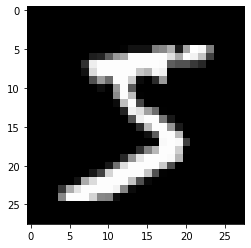

In [4]:
image, label = dataset[0]
print('image.shape: ', image.shape)
plt.imshow(image[0], cmap='gray')
print('label: ', label)

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

images.shape:  torch.Size([128, 1, 28, 28])


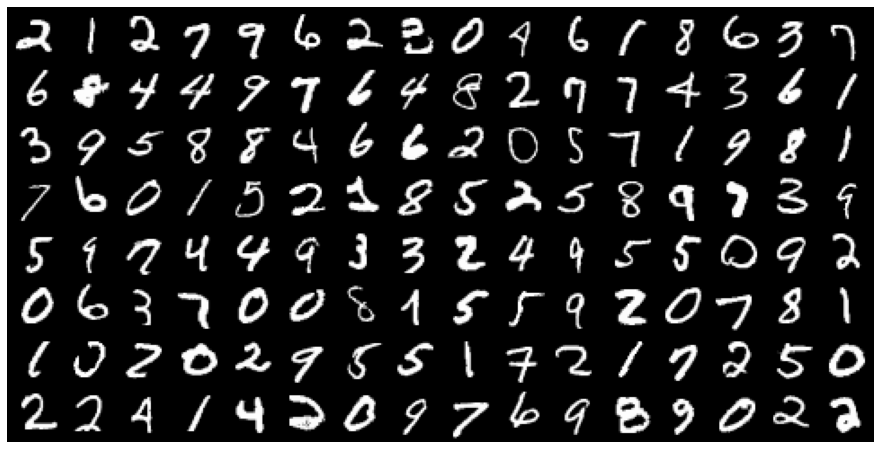

In [7]:
for images, _ in train_loader:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [8]:
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shapes: ', inputs.shape)
    break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shapes:  torch.Size([128, 784])


In [9]:
input_size = inputs.shape[-1]
hidden_size = 32

In [10]:
layer1 = nn.Linear(input_size, hidden_size)

In [11]:
inputs.shape

torch.Size([128, 784])

In [12]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape: ', layer1_outputs.shape)

layer1_outputs.shape:  torch.Size([128, 32])


In [13]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [14]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [15]:
F.relu(torch.tensor([[1, -1, 0],
                    [-0.1, 0.2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [16]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs): ', torch.min(layer1_outputs).item())
print('min(relu_outputs): ', torch.min(relu_outputs).item())

min(layer1_outputs):  -0.7796168327331543
min(relu_outputs):  0.0


In [17]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [18]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [19]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3243, grad_fn=<NllLossBackward>)

In [20]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias)

In [21]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [22]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [23]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [24]:
# same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [25]:
torch.allclose(outputs2, outputs3, 1e-3)

False

In [26]:
class MnistModel(nn.Module):
    """Feedforward neural netwrok with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply active function
        out = F.relu(out)
        # get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        acc = accuracy(out, labels)         # calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()          # combine accuracies         
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [29]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [30]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [33]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss: ', loss.item())
    break
    
print('outputs.shape: ', outputs.shape)
print('Sample outputs:\n', outputs[:2].data)

Loss:  2.3223438262939453
outputs.shape:  torch.Size([128, 10])
Sample outputs:
 tensor([[-0.0802,  0.2055, -0.1822,  0.0533,  0.0761,  0.1313, -0.0676,  0.1825,
          0.0925, -0.1994],
        [-0.0294,  0.2651, -0.1771,  0.0631,  0.0717,  0.0303,  0.0061,  0.1142,
          0.0571, -0.0882]])


In [34]:
torch.cuda.is_available()

False

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [36]:
device = get_default_device()
device

device(type='cpu')

In [37]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [38]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [39]:
class DeviceDataLoader():
    """wrap a dataloader to move data to a device."""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
def some_numbers():
    yield 10
    yield 20
    yield 30
    
for value in some_numbers():
    print(value)

10
20
30


In [41]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [42]:
for xb, yb in val_loader:
    print('xb.device: ', xb.device)
    print('yb.device: ', yb.device)
    break

xb.device:  cpu
yb.device:  cpu


In [47]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [48]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [49]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3062119483947754, 'val_acc': 0.08514636009931564}]

In [50]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2474, val_acc: 0.9248
Epoch [1], val_loss: 0.1717, val_acc: 0.9526
Epoch [2], val_loss: 0.1485, val_acc: 0.9580
Epoch [3], val_loss: 0.1373, val_acc: 0.9590
Epoch [4], val_loss: 0.1515, val_acc: 0.9563


In [51]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1249, val_acc: 0.9640
Epoch [1], val_loss: 0.1210, val_acc: 0.9653
Epoch [2], val_loss: 0.1205, val_acc: 0.9652
Epoch [3], val_loss: 0.1207, val_acc: 0.9651
Epoch [4], val_loss: 0.1213, val_acc: 0.9650


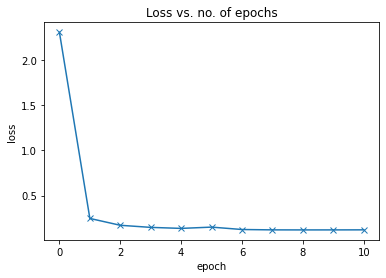

In [53]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. no. of epochs');

Text(0.5, 1.0, 'Accuracy vs. no. of epochs')

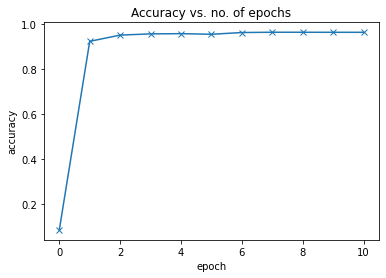

In [54]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. no. of epochs')

In [55]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                    transform=ToTensor())

In [56]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label:  7 , Predicted: 7


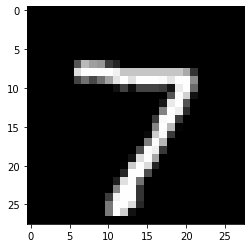

In [57]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ', Predicted:', predict_image(img, model))

Label:  2 , Predicted: 2


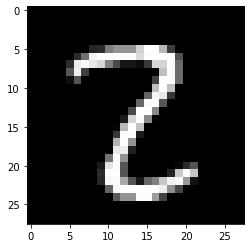

In [58]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ', Predicted:', predict_image(img, model))

Label:  9 , Predicted: 9


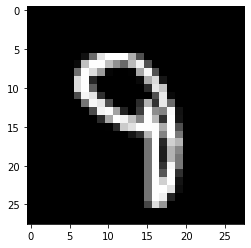

In [59]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ', Predicted:', predict_image(img, model))

In [60]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10233460366725922, 'val_acc': 0.9693359136581421}

In [61]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')